## Aprenentatge autmátic - Práctica 1
### Classificació d'imatges emprant SVM

L'objectiu d'aquesta primera pràctica de l'assignatura aprenentatge automàtic es l'obtenció del millor SVM possible, hem obtat per el dataset dels paissatges ja que creim que aprendrem més i que ens servirà per a la realització del TFG.

Com ens indiquen a l'encunciat tenim un conjunt d'imatges en una escala de grisos sense gaire preprocesament, les imatges ja venen separades en el test amb unes 3100 mostres i el train amb unes 1500 imatges, això de primeres ens sorpren una mica ja que tenim mes mostres de test (~2/3) que de train.

El primer que farem sera mirar les nostres dades i extreure informació que ens pugi ser útil.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.feature import hog
from skimage import data, exposure, feature, io, color
import os
import pandas as pd
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score , confusion_matrix
import cv2 as cv
from skimage import io, transform
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
warnings.filterwarnings('ignore')

## Tractament i exploració de dades

El primer que farem sera mirar quines categories d'imatges tenim i visualitzarem una imatge de cada cateogria. Ademés declararen els punters a les dades de train, de test i ell llistat de categories ja que els emprarem durant tota la práctica

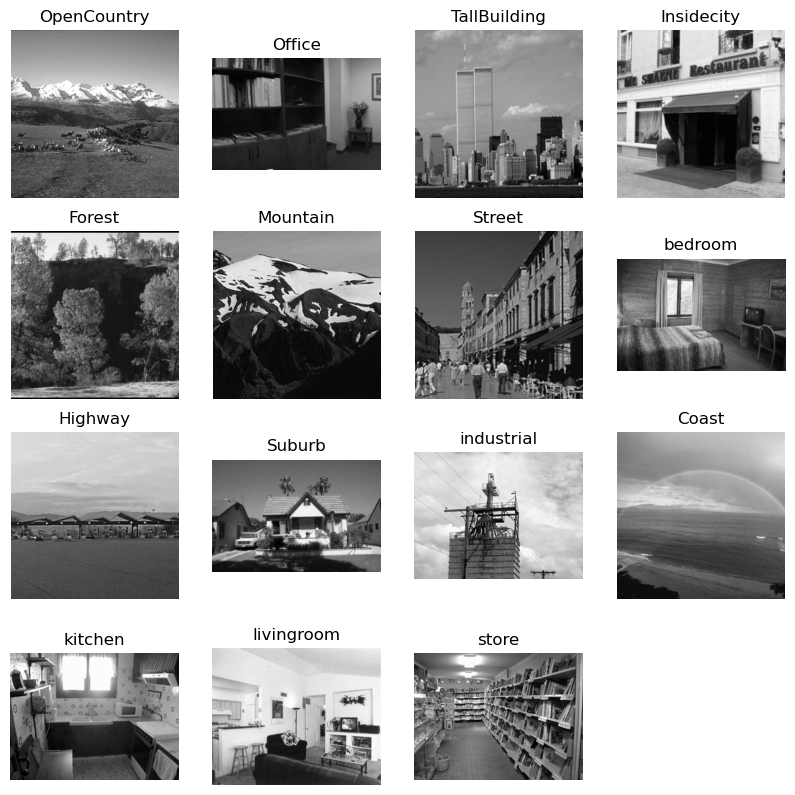

In [2]:
test_path = 'a2/test'
train_path = 'a2/train'

categories = os.listdir(train_path)

def show_categories(categories, train_path):
    plt.figure(figsize=(10, 10))
    for i, category in enumerate(categories):
        image_path = os.path.join(train_path, category)
        image_in_folder = os.listdir(image_path)
        first_image = image_in_folder[0]
        first_image_in_path = os.path.join(image_path, first_image)
        img = imread(first_image_in_path)
        plt.subplot(4, 4, i + 1)
        
        plt.imshow(img, cmap="gray");

        # plt.imshow(img, cmap='gray')
        plt.title(category)
        plt.axis('off')
    plt.show()

show_categories(categories, train_path)

Com podem observar tenim un total de 15 categories difrents i molt variades, desde d'interior d'una tenda com una carretera o una muntaña, el seguent pas que farem sera convertir les imatges a un dataset, per això recorrerem totes les imatges i les tranformarem a un vector unideimensional emprant la funció `flatten()` del paquet `NumPy`, en el nostre cas s'obté un vector unidimensional que conté tots els valors de píxels de la imatge en una seqüència lineal.

In [167]:

def convertImageData(categories, data_path):
    # Definir listas para almacenar datos
    data = []
    labels = []

    # Tamaño de redimensionamiento deseado
    new_size = (75, 75)

    # Recorrer cada categoría
    for category in categories:
        path = os.path.join(data_path, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = io.imread(img_path)
            # Redimensionar la imagen
            resized_image = transform.resize(image, new_size)
            # Aplanar la imagen en un vector unidimensional
            feature_vector = resized_image.flatten()

            # Agregar el vector de características y la etiqueta a las listas de datos
            data.append(feature_vector)
            labels.append(categories.index(category))

    return data, labels

data, labels = convertImageData(categories, train_path)

df = pd.DataFrame(data)
df['label'] = labels

# Mostrar el DataFrame
print(df.shape)

(1499, 5626)


Ara que ja tenim totes les imatges a un dataframe amb els valors convertits podem visualitzar quin percentatje de dades tenim de cada categoria per si es necesari fer un ajustament de les dades, ja que si una categoria es molt major que una altra no aprendra de manera equivalent i estarà molt més especialitzat en una catgeoria i això no ens interesa.

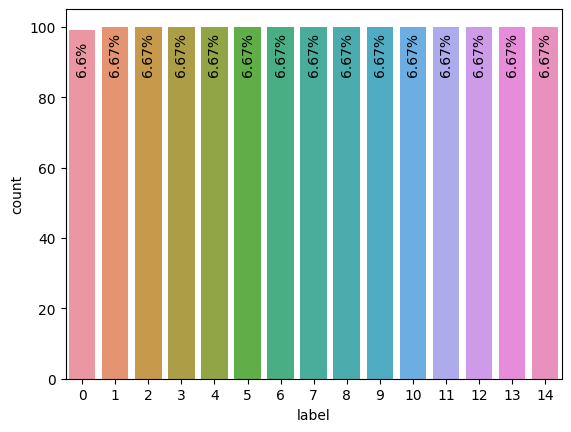

In [173]:
percentage = (df['label'].value_counts(normalize=True) * 100).round(2)

ax = sns.countplot(x="label", data=df)

for index, p in enumerate(ax.patches):
    ax.annotate(f'{percentage[index]}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, -20), textcoords='offset points', rotation=90)

Com podem observar el percentatje de cada categoria es molt parescut, si no casi identic, això en indica que tenim un porcentatge de dades molt ben balancetjat i no es necesari fer cap típues d'ajustament a les dades. 

A continuació mirarem com estan les dades de test:

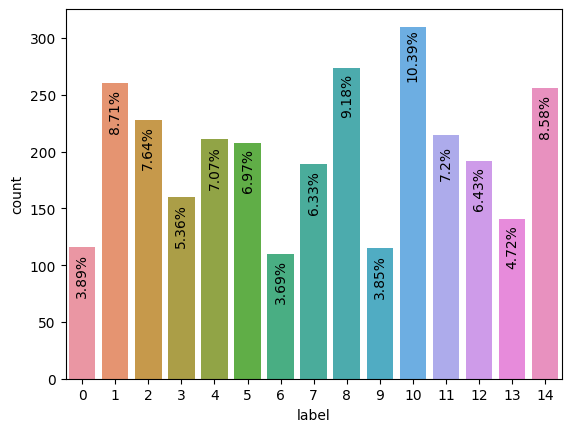

In [179]:
data, labels = convertImageData(categories, test_path)
df_test = pd.DataFrame(data)
df_test['label'] = labels

percentage = (df_test['label'].value_counts(normalize=True) * 100).round(2)

ax = sns.countplot(x="label", data=df_test)

for index, p in enumerate(ax.patches):
    ax.annotate(f'{percentage[index]}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, -20), textcoords='offset points', rotation=90)

Com podem observar el conjunt de test és molt més variat, això no ens suposa cap inconvenient ja que el nostre model ja haura estat entrenat, el que si és important es que no hi ha cap categoria que sigui null en el conjunt de test, si n'hi hagues alguna seria possible eliminar la categoria del conjunt d'entrenament ja que mai les prediuriem.

Una vegada hem fet una primera observació de les dades provarem a fer un parell de models per a veure quins resultats obtenim.

## Experimentació 

### Primer model. SVM bàsic

Provarem a fer un SVM basic sense fer cap modificació a les dades i observarem quins resultats ens dona, per a ell emprarem les dades del dataframe anterior on simplement feim un flatten de l'imatge. Per a poder fer l'entrenament necesitam separar les dades entre els valors extrets i la categoria associada. Posarem el flag `probability` a true per a no només obtenir a quina clase predim sinó que també obtenim tots els percentatges per les diferentes categories, això ens sera útil per poder observar quines categories confón o les quals no acaba d'estar segur entre un parell. 

In [ ]:
svm_basic = SVC(random_state=33, probability=True)

x_train = df.iloc[:,:-1]  
y_train = df.iloc[:,-1]

svm_basic.fit(x_train, y_train) 

Una vegada el nostre entrenament ha finalitzat podem fer prediccions amb aquest model, per a això hem d'emprar la funció `predict` on podem pasar un nombre N d'imatges per a prediure, els resultats els guardarem a una variable per a calcular les diferentes métriques.

In [ ]:
data, labels = convertImageData(categories, test_path)

y_pred = svm_basic.predict(data) 
accuracy = accuracy_score(y_pred, labels) 
  
print(f"The model is {accuracy*100}% accurate")

Com podem observar els resultats no són molt bons, un 31.22% és molt millorable encara que això es d'esperar ja que no hem aplicat cap extractor de característiques sinò que hem passat l'imatge 'raw' al SVM. Anam a fer una matriu de confusió per a veure com classifica les diferents imatges.

In [ ]:
cf_matrix = confusion_matrix(labels, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=categories, yticklabels=categories)
plt.show()    

Podem observar de manera clara que la categoria de forest la confon tot el temps mentres que la que per la categoria street pareix que s'equivoca menys. El cas de pot ser a que són paissatges amb molt de reonou degut a les fulles i com esteim fent el faltten que no té en compte el principi de localitat i tampoc aplicam cap extractor pot detectar que hi ha molt de renou a les imatges i alomillor les classifica com forest.

Anam a observar una imatge d'una classe aleatoria per observar els percentatges

In [ ]:
image = imread('/a2/test/street/image_0007.jpg')
plt.imshow(image, cmap="gray") 
plt.show() 
img_resize = transform.resize(image,(75,75)) 
l=[img_resize.flatten()] 
probability = svm_basic.predict_proba(l)[0]

dfData = [{"Category": categories[i], "Prob": prob} for i, prob in enumerate(probability)]
df = pd.DataFrame(dfData)

ax = sns.barplot(x='Category', y='Prob', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 15), rotation=90, textcoords='offset points')

plt.show()
print("The predicted image is: " + categories[svm_basic.predict(l)[0]])

Ara provarem a fer un preprocesament de les dades per intentar millorar els resultats, per això aplicarem HOG a les imatges i repetirem el procés.

### HOG

In [4]:
from skimage.feature import hog

def convertImageDataHOG(categories, data_path, dim = (100,100),  flip = False, categoriesToExclude = []):
    # Definir listas para almacenar datos
    data = []
    labels = []

    # HOG parameters
    orientations = 13
    pixels_per_cell = (5, 5)
    cells_per_block = (4, 4)

 
    
    new_categories = [item for item in categories if item not in categoriesToExclude]
    # Recorrer cada categoría
    for category in new_categories:
        path = os.path.join(data_path, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = io.imread(img_path)

            # Redimensionar la imagen
            images = [transform.resize(image, dim)]            
            if(flip): 
                images.append(cv.flip(images[0], flipCode=1))
            
            for img in images: 
                # Aplicar HOG al resized_image
                hog_features = hog(img,
                                   orientations=orientations,
                                   pixels_per_cell=pixels_per_cell,
                                   cells_per_block=cells_per_block,
                                   visualize=False)
                
                # Agregar el vector de características HOG y la etiqueta a las listas de datos
                data.append(hog_features)

                labels.append(categories.index(category))
            

    return data, labels

In [5]:
dataHOG, labelsHOG = convertImageDataHOG(categories, train_path, flip = True)

dfHOG = pd.DataFrame(dataHOG)
dfHOG['label'] = labelsHOG

# Mostrar el DataFrame
print(dfHOG)

             0         1         2         3         4         5         6  \
0     0.032762  0.000000  0.000000  0.000000  0.000000  0.105117  0.243699   
1     0.031014  0.000000  0.000000  0.000000  0.028303  0.164589  0.141754   
2     0.029796  0.000000  0.000000  0.000000  0.000000  0.000000  0.193807   
3     0.010828  0.000000  0.000000  0.000000  0.000000  0.003043  0.125452   
4     0.086551  0.000000  0.000000  0.000000  0.000000  0.000000  0.063907   
...        ...       ...       ...       ...       ...       ...       ...   
2993  0.089597  0.136135  0.131004  0.000000  0.004419  0.004558  0.053270   
2994  0.013059  0.000000  0.000000  0.000000  0.000000  0.000000  0.261862   
2995  0.020904  0.006492  0.006124  0.003252  0.000901  0.000000  0.001475   
2996  0.014158  0.005002  0.003817  0.003256  0.000000  0.008649  0.102023   
2997  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.165815   

             7         8         9  ...     60103     60104    

In [6]:
svm_HOG = SVC(random_state=33, probability=True)

x_train_hog = dfHOG.iloc[:,:-1]  
y_train_hog = dfHOG.iloc[:,-1]

svm_HOG.fit(x_train_hog, y_train_hog) 

SVC(probability=True, random_state=33)

In [7]:
dataHOG, labelsHOG = convertImageDataHOG(categories, test_path)

y_pred_hog = svm_HOG.predict(dataHOG) 
# Calculating the accuracy of the model 
accuracy_hog = accuracy_score(y_pred_hog, labelsHOG) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy_hog*100}% accurate")

The model is 66.36515912897822% accurate


In [ ]:
def hogTrainAndTest(svm_HOG,data, dim, labels):
    x_train_hog = dfHOG.iloc[:,:-1]  
    y_train_hog = dfHOG.iloc[:,-1]

    svm_HOG.fit(x_train_hog, y_train_hog) 
    print("Model fitted")
    dataHOG, labelsHOG = convertImageDataHOG(categories, test_path, dim)

    y_pred_hog = svm_HOG.predict(dataHOG) 
    # Calculating the accuracy of the model 
    accuracy_hog = accuracy_score(y_pred_hog, labelsHOG) 

    # Print the accuracy of the model 
    print(f"The model is {accuracy_hog*100}% accurate")
    

In [ ]:
image = imread('a2/test/tallbuilding/image_0057.jpg')
plt.imshow(image, cmap="gray") 
plt.show() 
img = transform.resize(image, (100,100))          
orientations = 13
pixels_per_cell = (5, 5)
cells_per_block = (4, 4)
img = [hog(img,orientations,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,
                   visualize=False)]


probability=svm_HOG.predict_proba(img) 
for ind,val in enumerate(categories): 
    print(f'{val} = {probability[0][ind]*100}%') 
print("The predicted image is : "+categories[svm_HOG.predict(img)[0]])


In [ ]:
cf_matrix = confusion_matrix(labelsHOG, y_pred_hog)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()    

from sklearn.metrics import classification_report

# Calculating the classification report
report = classification_report(labelsHOG, y_pred_hog, target_names=categories)

# Print the classification report
print(report)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Define the parameter grid for the grid search
param_grid = {'C': [1, 10, 100],
              'gamma': ["auto", "scale"],
              'kernel': ['rbf', 'linear', "poly"]}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVC(random_state=33, probability=True), param_grid, verbose=3, cv=KFold(n_splits=5, random_state=10, shuffle=True))

# Fit the grid search to the data
grid_search.fit(x_train_hog, y_train_hog)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


In [ ]:
svm_HOG_grid = SVC(C=1.0, gamma="scale", kernel='rbf', random_state=33, probability=True)

svm_HOG_grid.fit(x_train_hog, y_train_hog) 

y_pred_hog = svm_HOG_grid.predict(dataHOG) 
# Calculating the accuracy of the model 
accuracy_hog_grid = accuracy_score(y_pred_hog, labelsHOG) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy_hog_grid*100}% accurate")

In [ ]:
# Load the image
image = imread('test.jpg')
plt.imshow(image, cmap="gray")
plt.show()

# HOG parameters
orientations = 9
pixels_per_cell = (4, 4)
cells_per_block = (1, 1)

# Resize the image
img_resize = transform.resize(image, (150, 150))

# Calculate HOG features
hog_features, hog_image = hog(img_resize,
                              orientations=orientations,
                              pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block,
                              visualize=True)

# Visualize HOG features
plt.imshow(hog_image, cmap="gray")
plt.show()

# Use the trained SVM model for prediction
probability = svm_HOG.predict_proba([hog_features])

# Show the prediction results
for ind, val in enumerate(categories):
    print(f'{val} = {probability[0][ind] * 100}%')

# Print the predicted image
print("The predicted image is: " + categories[svm_HOG.predict([hog_features])[0]])


----

## Combine hog and lbp


In [8]:
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import MinMaxScaler

def convertImageDataHOG_LBP(categories, data_path, dim = (100,100),  flip = False, categoriesToExclude = []):
    # Definir listas para almacenar datos
    data = []
    labels = []

    # HOG parameters
    orientations = 13
    pixels_per_cell = (5, 5)
    cells_per_block = (4, 4)
    
    # LBP parameters
    lbp_radius = 4
    lbp_n_points = 8 * lbp_radius
    method = 'uniform'
    scaler = MinMaxScaler(feature_range=(0, 1))

    new_categories = [item for item in categories if item not in categoriesToExclude]
    # Recorrer cada categoría
    for category in new_categories:
        path = os.path.join(data_path, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = io.imread(img_path)

            # Redimensionar la imagen
            images = [transform.resize(image, dim)]            
            if(flip): 
                images.append(cv.flip(images[0], flipCode=1))
            
            for img in images: 
                # Aplicar HOG al resized_image
                hog_features = hog(img,
                                   orientations=orientations,
                                   pixels_per_cell=pixels_per_cell,
                                   cells_per_block=cells_per_block,
                                   visualize=False)
                
                hog_reshape = hog_features.reshape(-1, 1)
                hog_features_normalized = scaler.fit_transform(hog_reshape)
                
                lbp_features = local_binary_pattern(img, lbp_n_points, lbp_radius, method)
                lbp_reshape = lbp_features.reshape(-1, 1)
                lbp_features_normalized = scaler.fit_transform(lbp_reshape)

                # Agregar el vector de características HOG y la etiqueta a las listas de datos
                data.append(np.concatenate([hog_features_normalized.ravel(), lbp_features_normalized.ravel()]))

                labels.append(categories.index(category))
            

    return data, labels 

dataHOG_LBP, labelsHOG_LBP = convertImageDataHOG_LBP(categories, train_path, flip = True)

dfHOG_LBP = pd.DataFrame(dataHOG_LBP)
dfHOG_LBP['label'] = labelsHOG_LBP

# Mostrar el DataFrame
print(dfHOG_LBP)

             0         1         2         3         4         5         6  \
0     0.104263  0.000000  0.000000  0.000000  0.000000  0.334524  0.775548   
1     0.098698  0.000000  0.000000  0.000000  0.090071  0.523789  0.451120   
2     0.089136  0.000000  0.000000  0.000000  0.000000  0.000000  0.579773   
3     0.032392  0.000000  0.000000  0.000000  0.000000  0.009104  0.375289   
4     0.260825  0.000000  0.000000  0.000000  0.000000  0.000000  0.192587   
...        ...       ...       ...       ...       ...       ...       ...   
2993  0.360797  0.548203  0.527540  0.000000  0.017796  0.018356  0.214514   
2994  0.038074  0.000000  0.000000  0.000000  0.000000  0.000000  0.763475   
2995  0.060946  0.018927  0.017855  0.009482  0.002628  0.000000  0.004301   
2996  0.045786  0.016175  0.012346  0.010531  0.000000  0.027969  0.329942   
2997  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.536246   

             7         8         9  ...     70103     70104    

In [9]:
svm_HOG_LBP = SVC(random_state=33, probability=True)

x_train_hog_lbp = dfHOG_LBP.iloc[:,:-1]  
y_train_hog_lbp = dfHOG_LBP.iloc[:,-1]

svm_HOG_LBP.fit(x_train_hog_lbp, y_train_hog_lbp) 

SVC(probability=True, random_state=33)

In [10]:
dataHOG_LBP_test, labelsHOG_LBP_test = convertImageDataHOG_LBP(categories, test_path)

y_pred_hog_lbp = svm_HOG_LBP.predict(dataHOG_LBP_test) 
# Calculating the accuracy of the model 
accuracy_hog_lbp = accuracy_score(y_pred_hog_lbp, labelsHOG_LBP_test) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy_hog_lbp*100}% accurate")

The model is 65.25963149078727% accurate


In [15]:
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
    svm_HOG_LBP,
    dataHOG_LBP_test, 
    labelsHOG_LBP_test, 
    param_range=[1.0],
    param_name="gamma", 
    scoring="accuracy",
    n_jobs=-1
)

display = ValidationCurveDisplay(param_range, train_scores, test_scores, xlabel="gamma")
display.plot()
plt.show()

KeyboardInterrupt: 

 # Experimentació
 


 ### Data Augmentation (flip):
 To try: o-13, 100x100 ppc= 5, flip = true, cpb = 4 (62,71 amb 75x75) i la meitat de dades

Proves:

In [10]:
dataHOG, labelsHOG = convertImageDataHOG(categories, train_path, (75,75), flip = False)

dfHOG = pd.DataFrame(dataHOG)
dfHOG['label'] = labelsHOG

# Mostrar el DataFrame
print(dfHOG.shape)

(1499, 29953)


In [13]:
svm_HOG = SVC(random_state=33, probability=True)

hogTrainAndTest(svm_HOG,dataHOG, (75,75), labelsHOG)

Model fitted
The model is 62.68006700167504% accurate


Veient com el que mes es confon son les habitacions amb els menjadors, nam a provar d'eliminar la classe habitació:

In [5]:

dataHOG, labelsHOG = convertImageDataHOG(categories, 
                                         train_path,(75,75),
                                         categoriesToExclude = ["bedroom"],
                                         flip = False)

dfHOG = pd.DataFrame(dataHOG)
dfHOG['label'] = labelsHOG

# Mostrar el DataFrame
print(dfHOG.shape)

(1400, 29953)


In [6]:
svm_HOG = SVC(random_state=33, probability=True)

hogTrainAndTest(svm_HOG,dataHOG,(75,75), labelsHOG)

Model fitted
The model is 62.043551088777214% accurate


Un altre cas de conflicte seria la categoria de les cuines, nam a veure a mem si les llevam:

In [11]:

dataHOG, labelsHOG = convertImageDataHOG(categories,
                                         train_path,
                                         (75,75),
                                         categoriesToExclude = ["kitchen"],
                                         flip = False)

dfHOG = pd.DataFrame(dataHOG)
dfHOG['label'] = labelsHOG

# Mostrar el DataFrame
print(dfHOG.shape)

(1399, 29953)


In [12]:
svm_HOG = SVC(random_state=33, probability=True)

hogTrainAndTest(svm_HOG,dataHOG,(75,75), labelsHOG)

Model fitted
The model is 61.97654941373534% accurate


Combinant el fet d'eliminar els casos conflictius:

In [13]:
dataHOG, labelsHOG = convertImageDataHOG(categories,
                                         train_path,
                                         (75,75),
                                          categoriesToExclude = ["bedroom","kitchen"],
                                         flip = False)

dfHOG = pd.DataFrame(dataHOG)
dfHOG['label'] = labelsHOG

# Mostrar el DataFrame
print(dfHOG.shape)

(1300, 29953)


In [14]:
svm_HOG = SVC(random_state=33, probability=True)

hogTrainAndTest(svm_HOG,dataHOG,(75,75), labelsHOG)

Model fitted
The model is 61.50753768844221% accurate


## Daisy Dense


In [11]:
from skimage.feature import daisy
from skimage import data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


def convertImageDataDaisy(categories, data_path, dim = (100,100),  flip = False, categoriesToExclude = []):
    # Definir listas para almacenar datos
    data = []
    labels = []
    
   #Daisy parameters
    step = 35
    radius = 17
    rings = 2
    histograms = 9
    orientations = 13
    

    scaler = MinMaxScaler(feature_range=(0, 1))

    new_categories = [item for item in categories if item not in categoriesToExclude]
    # Recorrer cada categoría
    for category in new_categories:
        path = os.path.join(data_path, category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = io.imread(img_path)

            # Redimensionar la imagen
            images = [transform.resize(image, dim)]            
            if(flip): 
                images.append(cv.flip(images[0], flipCode=1))
            
            for img in images: 
                # Aplicar HOG al resized_image
                descs, descs_img = daisy(img, step, radius, rings, histograms,
                         orientations, visualize=True)
                
                daisy_reshape = descs_img.reshape(-1, 1)
                daisy_features_normalized = scaler.fit_transform(daisy_reshape)

                # Agregar el vector de características HOG y la etiqueta a las listas de datos
                data.append(daisy_features_normalized.ravel())

                labels.append(categories.index(category))
            

    return data, labels 

dataDaisy, labelsDaisy = convertImageDataDaisy(categories, train_path, (75,75), flip =True)

dfDaisy = pd.DataFrame(dataDaisy)
dfDaisy['label'] = labelsDaisy

# Mostrar el DataFrame
print(dfDaisy.shape)

(2998, 16876)


In [12]:
svm_Daisy = SVC(random_state=33, probability=True)

x_train_Daisy = dfDaisy.iloc[:,:-1]  
y_train_Daisy = dfDaisy.iloc[:,-1]

svm_Daisy.fit(x_train_Daisy, y_train_Daisy) 

SVC(probability=True, random_state=33)

In [13]:
dataDaisy, labelsDaisy = convertImageDataDaisy(categories, test_path, (75,75))

y_pred_Daisy = svm_Daisy.predict(dataDaisy) 
# Calculating the accuracy of the model 
accuracy_Daisy = accuracy_score(y_pred_Daisy, labelsDaisy) 
  
# Print the accuracy of the model 
print(f"The model is {accuracy_Daisy*100}% accurate")

The model is 55.812395309882746% accurate


### ENSAMBLER!

In [15]:
#SuperClassificadorSuperGuay = VotingClassifier(
#     estimators=[('Hog', svm_HOG), ('HogLbp', svm_HOG_LBP), ('Daisy', svm_Daisy)],
#     voting='hard')

models = [svm_Daisy]
transformers = [daisyFormat]

In [14]:
from collections import Counter

def daisyFormat(image_path, dim):    
   #Daisy parameters
    step = 35
    radius = 17
    rings = 2
    histograms = 7
    orientations = 13
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    data = []

    image = io.imread(image_path)

    # Redimensionar la imagen
    image = transform.resize(image, (75,75))            
    # Aplicar HOG al resized_image
    descs, descs_img = daisy(image, step, radius, rings, histograms,
             orientations, visualize=True)

    daisy_reshape = descs_img.reshape(-1, 1)
    daisy_features_normalized = scaler.fit_transform(daisy_reshape)

    # Agregar el vector de características HOG y la etiqueta a las listas de datos
    data.append(daisy_features_normalized.ravel())

    return data 

def hogFormat(image_path, dim):
    data = []

    orientations = 13
    pixels_per_cell = (5, 5)
    cells_per_block = (4, 4)

    image = io.imread(image_path)

    image = transform.resize(image, dim)           
    hog_features = hog(image,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       visualize=False)
    data.append(hog_features)
    return data  

def hogLbpFormat(image_path, dim):
    data = []

    orientations = 13
    pixels_per_cell = (5, 5)
    cells_per_block = (4, 4)
    
    lbp_radius = 4
    lbp_n_points = 8 * lbp_radius
    method = 'uniform'
    scaler = MinMaxScaler(feature_range=(0, 1))

    image = io.imread(image_path)

    # Redimensionar la imagen
    image = transform.resize(image, dim)            

    hog_features = hog(image,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       visualize=False)

    hog_reshape = hog_features.reshape(-1, 1)
    hog_features_normalized = scaler.fit_transform(hog_reshape)

    lbp_features = local_binary_pattern(image, lbp_n_points, lbp_radius, method)
    lbp_reshape = lbp_features.reshape(-1, 1)
    lbp_features_normalized = scaler.fit_transform(lbp_reshape)

    # Agregar el vector de características HOG y la etiqueta a las listas de datos
    data.append(np.concatenate([hog_features_normalized.ravel(), lbp_features_normalized.ravel()]))
    return data 
    
    
def votingClassifier(models, transformers, path, debug = False):
    converted = []
    for transformer in transformers:
        converted.append(transformer(path, (100,100)))
    
    probabilities = []
    for index, model in enumerate(models):
        probability = model.predict_proba(converted[index])[0]
        max_probability_index = probability.argmax()
        max_probability = probability[max_probability_index]
        probabilities.append((max_probability_index, max_probability))
       
    # print(probabilities)
    max_indices = [index for index, _ in probabilities]
    max_probabilities = [prob for _, prob in probabilities]

    counter = Counter(max_indices)
    most_common = counter.most_common(1)
    most_common_value, most_common_count = most_common[0] if most_common else (None, 0)

    if most_common_count > len(max_indices) / 2:
        if(debug):
            return categories[most_common_value]
        else:
            return most_common_value

    else:
        most_sure = max(max_probabilities)
        most_sure = [item for item in probabilities if item[1] == most_sure][0]
        if(debug):
            return [categories[most_sure[0]], most_sure[1]]
        else:
            return most_sure[0]
        
# 'a2/test/insidecity/image_0303.jpg'
votingClassifier([svm_HOG, svm_HOG_LBP, svm_Daisy], [hogFormat, hogLbpFormat, daisyFormat], 'test.jpg')

7

In [ ]:
results = []
for category in categories:
    path = os.path.join(test_path, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        results.append(votingClassifier([svm_HOG, svm_HOG_LBP, svm_Daisy], [hogFormat, hogLbpFormat, daisyFormat], img_path)) 

In [ ]:
cf_matrix = confusion_matrix(labels, results)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=categories, yticklabels=categories)
plt.show()   